Import of libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.metrics import MeanAbsoluteError as mean_absolute_error
import warnings
import keras_tuner as kt
import tensorflow_addons as tfa

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
# tf.debugging.set_log_device_placement(True)

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)


2022-03-17 14:28:15.480262: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda-11.2/targets/x86_64-linux/lib
2022-03-17 14:28:15.480327: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.6.2
Num GPUs Available:  0


2022-03-17 14:28:32.737218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 14:28:32.738063: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda-11.2/targets/x86_64-linux/lib
2022-03-17 14:28:32.738297: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda/extras/CUPTI/

import of drive and seeds

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

exploring the dataset

In [3]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


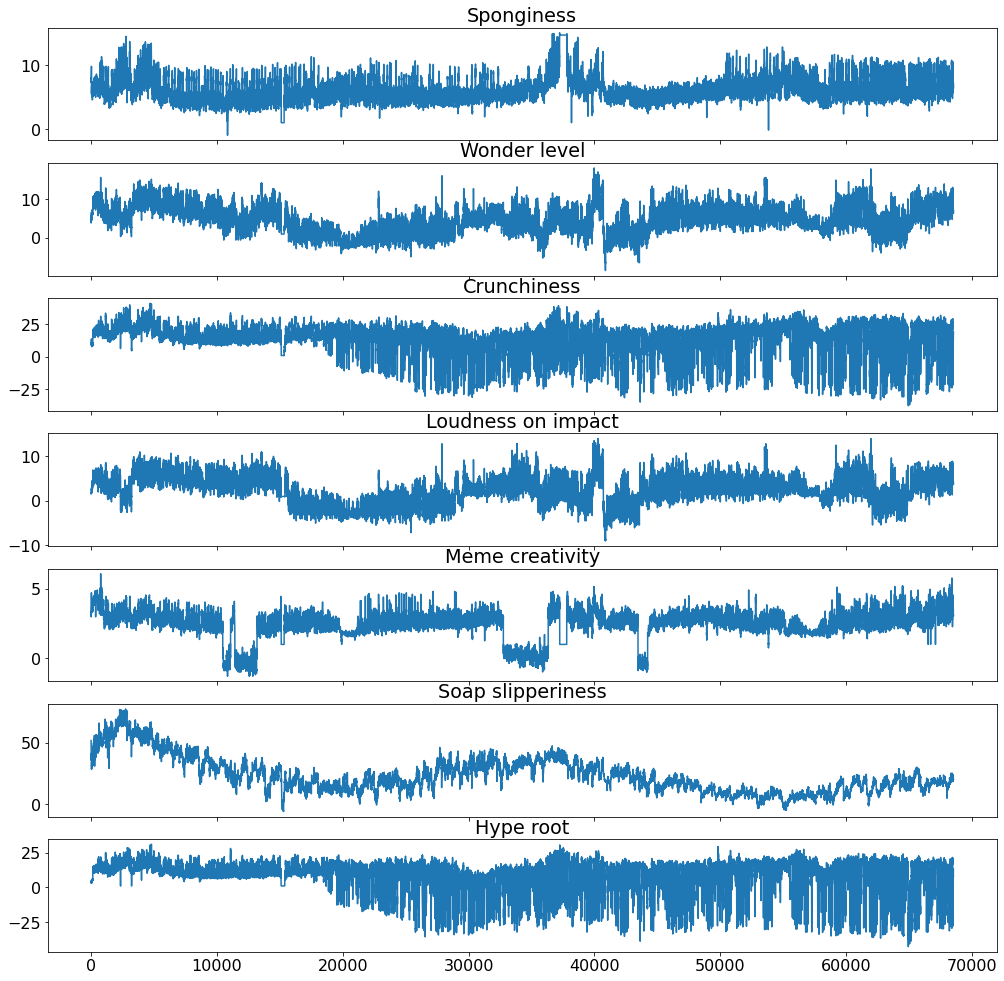

In [5]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

(63000, 7) (5528, 7)


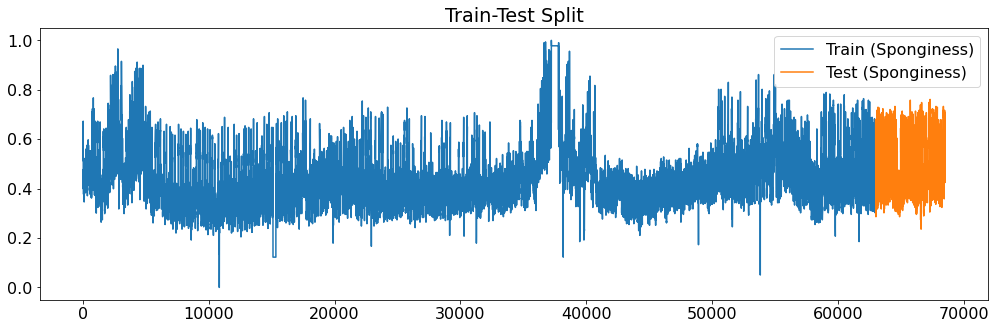

In [6]:
test_size = 5528
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (Sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [7]:
target_labels = dataset.columns

In [ ]:
class HyperModel(kt.HyperModel):
    #optimizer
 
    def build(self,hp):
        window,stride,telescope,future = self.getWindowAndTelescope(hp)
        print("Window, Stride, Telescope")
        print(window,stride,telescope)
        X_train, y_train = self.build_sequences(df = X_train_raw, window = window, stride = stride, telescope = telescope)
        input_shape = X_train.shape[1:]
        output_shape = y_train.shape[1:]
            # Build the neural network layer by layer
        print("Input & Output Shape Model")
        print(input_shape, output_shape)
     
        input_layer = tfkl.Input(shape=input_shape, name='Input')

        convlstm = tfkl.Conv1D(filters = hp.Int('unitsConv_1', min_value=32, max_value=128, step=16), kernel_size=hp.Int('kernel_size_1', min_value=1, max_value=7, step=1), padding='same')(input_layer)
        convlstm = tfkl.LeakyReLU(alpha = hp.Float('alpha_1', min_value = 0.1, max_value = 0.9, step = .1))(convlstm)
        convlstm = tfkl.Conv1D(filters = hp.Int('unitsConv_2', min_value=64, max_value=256, step=16), kernel_size=hp.Int('kernel_size_1', min_value=1, max_value=7, step=1), padding='same')(convlstm)
        convlstm = tfkl.LeakyReLU(alpha = hp.Float('alpha_1', min_value = 0.1, max_value = 0.9, step = .1))(convlstm)
        convlstm = tfkl.MaxPool1D()(convlstm)
        convlstm = tfkl.Conv1D(filters = hp.Int('unitsConv_3', min_value=128, max_value=512, step=16), kernel_size=hp.Int('kernel_size_1', min_value=1, max_value=7, step=1), padding='same')(convlstm)
        convlstm = tfkl.Dropout(hp.Float('unitsDrop_1', min_value=0.1, max_value=0.9, step=.1))(convlstm)
        convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
        dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
        output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
        output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

      
        model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

        # Compile the model
        model.compile(loss=tfk.losses.Huber(delta=1.5), optimizer=tfk.optimizers.Adam(), metrics=[tfk.metrics.RootMeanSquaredError(),'mae', tfa.metrics.RSquare(dtype=tf.float32, y_shape=(864,7))])

        # Return the model
        return model

    def fit(self, hp, model, *args, **kwargs):
        window,stride,telescope,future = self.getWindowAndTelescope(hp)
        X_train, y_train = self.build_sequences(df = X_train_raw, window = window, stride = stride, telescope = telescope)
        input_shape = X_train.shape[1:]
        output_shape = y_train.shape[1:]
            # Build the neural network layer by layer
        print("Input & Output Shape Fit")
        print(input_shape, output_shape)
        print(args)
        return model.fit(
            x = X_train,
            y = y_train,
            *args,
            **kwargs,
            )
            
    def getWindowAndTelescope(self, hp):
        window = hp.Choice('window', [50,100,150])
        stride = hp.Choice('stride', [2,5,10,50])
        future = dataset[-window:]
        future = (future-X_min)/(X_max-X_min)
        future = np.expand_dims(future, axis=0)
        future.shape
        telescope = 864
        return window,stride,telescope,future

    def build_sequences(self ,df, window, stride, telescope):
      print("Window & Stride:")
      print(window,stride)

      # Sanity check to avoid runtime errors
      assert window % stride == 0
      dataset = []
      labels = []
      temp_df = df.copy().values
      temp_label = df[target_labels].copy().values
      padding_len = len(df)%window

      if(padding_len != 0):
          # Compute padding length
          padding_len = window - len(df)%window
          padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
          temp_df = np.concatenate((padding,df))
          padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
          temp_label = np.concatenate((padding,temp_label))
          assert len(temp_df) % window == 0

      for idx in np.arange(0,len(temp_df)-window-telescope,stride):
          dataset.append(temp_df[idx:idx+window])
          labels.append(temp_label[idx+window:idx+window+telescope])

      dataset = np.array(dataset)
      labels = np.array(labels)
      return dataset, labels

  

In [ ]:
class MyTuner(kt.tuners.RandomSearch):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['validation_split'] = .1
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 8, 32, step=8)
    kwargs['callbacks'] = [
        tfk.callbacks.EarlyStopping(monitor='val_r_square', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_r_square', mode='max', patience=3, factor=0.5, min_lr=1e-5)
    ]
    return super(MyTuner, self).run_trial(trial, *args, **kwargs)
 

In [ ]:

tuner = MyTuner(
    hypermodel=HyperModel(),
    objective=kt.Objective('val_r_square',direction = "max"),
    max_trials=20, 
    overwrite=True, 
    directory='./TuningModels',
    project_name = "Model2"
)

In [ ]:

tuner.search_space_summary()

train on variuos model to get the best one

In [ ]:

tuner.search(epochs=30)


K-fold

In [ ]:
#ridefinition of build_sequences to use it outside of the Hypermodel class
def build_sequences(df,window, stride, telescope):
      print("Window & Stride:")
      print(window,stride)

      # Sanity check to avoid runtime errors
      assert window % stride == 0
      dataset = []
      labels = []
      temp_df = df.copy().values
      temp_label = df[target_labels].copy().values
      padding_len = len(df)%window

      if(padding_len != 0):
          # Compute padding length
          padding_len = window - len(df)%window
          padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
          temp_df = np.concatenate((padding,df))
          padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
          temp_label = np.concatenate((padding,temp_label))
          assert len(temp_df) % window == 0

      for idx in np.arange(0,len(temp_df)-window-telescope,stride):
          dataset.append(temp_df[idx:idx+window])
          labels.append(temp_label[idx+window:idx+window+telescope])

      dataset = np.array(dataset)
      labels = np.array(labels)
      return dataset, labels

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_r_square', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_r_square', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
hypermodel = HyperModel()
hp = tuner.get_best_hyperparameters()[0]
#model = hypermodel.build(hp)
num_folds = 10
window = hp.get_config()['values']['window']
stride = hp.get_config()['values']['stride']
telescope = 864
hp = tuner.get_best_hyperparameters()[0]
X_train, y_train = build_sequences(df=X_train_raw,window=window,stride=stride,telescope=telescope)
histories = []
scores = []
#models = []
kfold = KFold(n_splits=num_folds, shuffle=False)

for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):

  print("Starting training on fold num: {}".format(fold_idx+1))

  
  model = hypermodel.build(hp)
  print(hp.get_config()['values'])
  history = model.fit(
                  x = X_train[train_idx],
                  y = y_train[train_idx],
                  #validation_split = hp.get_config()['values']['validation_split'],
                  validation_data=(X_train[valid_idx], y_train[valid_idx]),
                  batch_size = tuner.get_best_hyperparameters()[0].get_config()['values']['batch_size'],
                  epochs = 200,
                  callbacks = callbacks
                  ).history
  score = model.evaluate(X_train[valid_idx], y_train[valid_idx])
  scores.append(score[1])
  model.save("modFold"+str(fold_idx))
  #at this point the code will generate 10 different model. To get the KFold model, you need to put them in another folder
  #(for example, our folder SubmissionModel contained all the 10 models: modFold1, modFold2,...modFold9).
  #This operation has been done by hand.
  histories.append(history)

MSE
Mean: 0.1099; STD: 0.0123


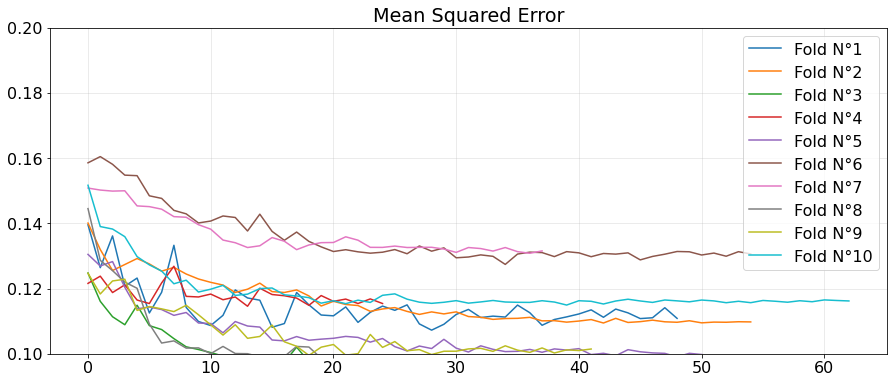

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

print("MSE")
print("Mean: {}; STD: {}".format(np.mean(scores).round(4), np.std(scores).round(4)))

plt.figure(figsize=(15,6))
for fold_idx in range(num_folds):
  plt.plot(histories[fold_idx]['val_root_mean_squared_error'], color=colors[fold_idx], label='Fold N°{}'.format(fold_idx+1))
  plt.ylim(0.10, 0.2)
  plt.title('Mean Squared Error')
  plt.legend(loc='upper right')
  plt.grid(alpha=.3)
plt.show()

Follows other plots and visualization of one of the 10 model 

In [ ]:
window,stride, telescope,future = hypermodel.getWindowAndTelescope(hp)

X_train, y_train = hypermodel.build_sequences(X_train_raw, window, stride, telescope)
X_test, y_test = hypermodel.build_sequences(X_test_raw, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

Window & Stride:
50 10
Window & Stride:
50 10


((6209, 50, 7), (6209, 864, 7), (464, 50, 7), (464, 864, 7))

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(464, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.012755309>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0841318>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()


# blue part is the 200 of the training , the orange part (100) the part that we awant to predict 
# this is an example

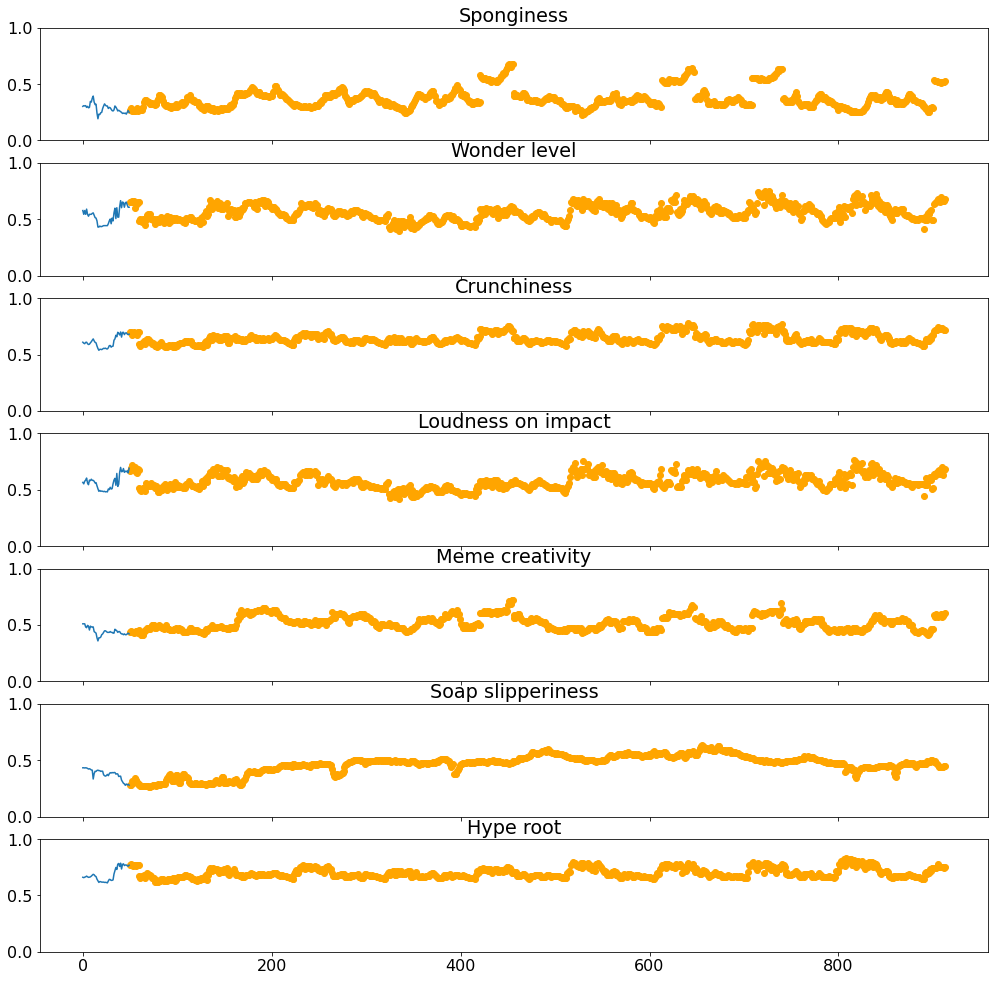

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

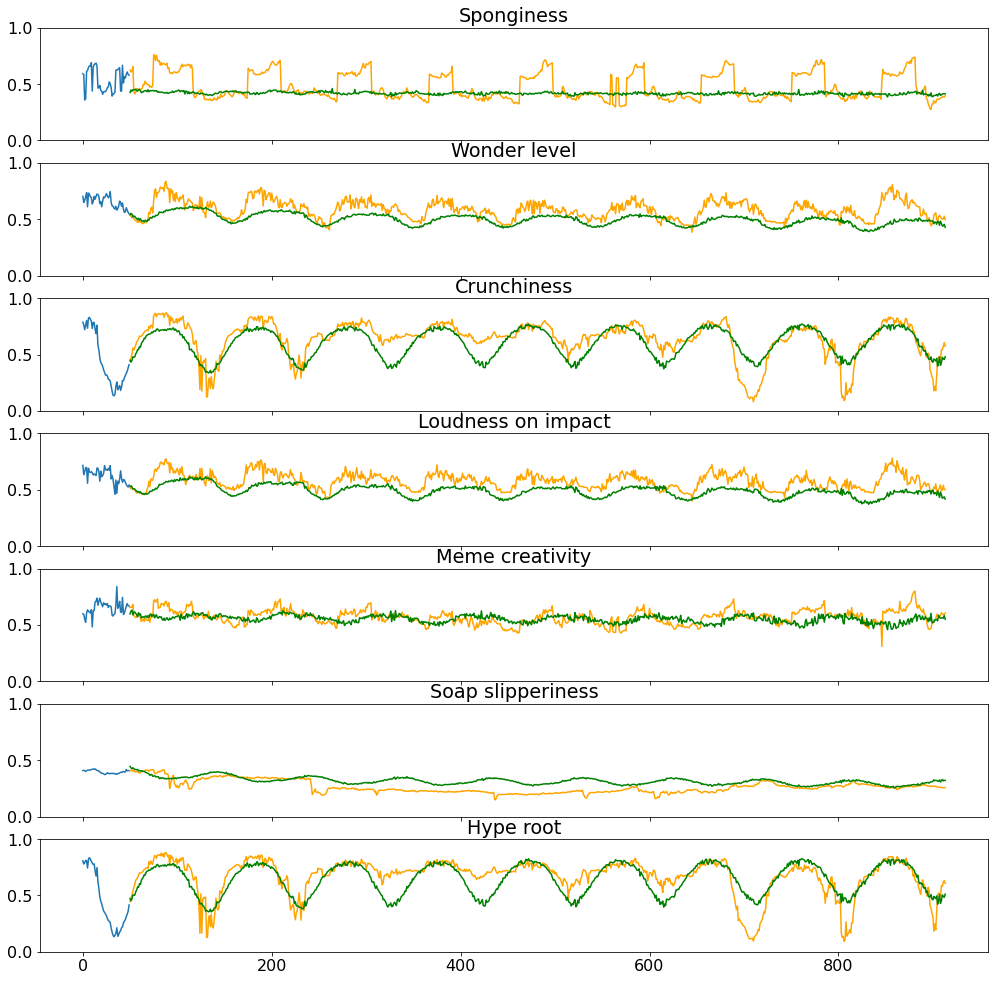

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
future_predictions = model.predict(future)

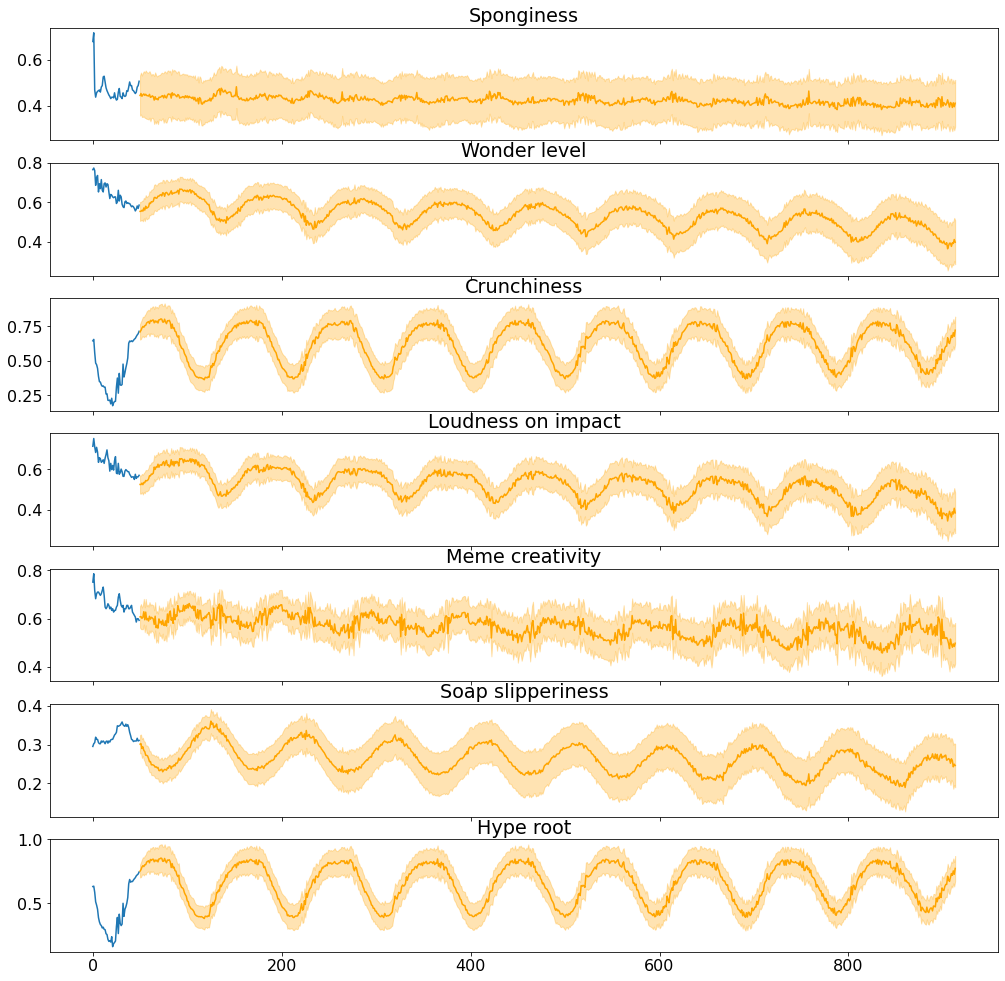

In [ ]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()